In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif,mutual_info_classif
from sklearn.utils import shuffle
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix
import time
df=pd.read_csv('/content/drive/MyDrive/smdm_data.csv')
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


In [2]:
data=df.iloc[:,:22]
data=data.to_numpy()

In [3]:
data=shuffle(data)

In [4]:
X=data[:,:21]
Y=data[:,21]


In [5]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [6]:
# Feature Selection
Z=pd.DataFrame(X)
W=pd.DataFrame(Y)
selector=SelectKBest(mutual_info_classif,k=11)
selector.fit(Z,W)
selector.transform(Z)
Z.columns[selector.get_support()]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Int64Index([1, 4, 7, 8, 9, 11, 12, 13, 16, 17, 19], dtype='int64')

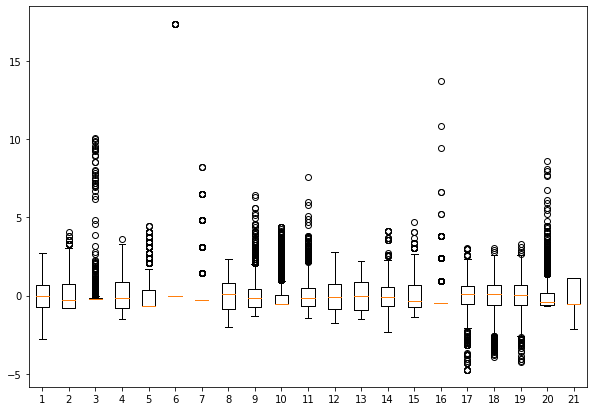

In [7]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(X)
plt.show()

In [33]:
encoder = LabelEncoder().fit(Y)
y_bool = encoder.transform(Y)
y = np_utils.to_categorical(y_bool)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
len_data = X.shape[0]
train_size = int(len_data * .7)
valid_size = int(len_data * .1)

In [10]:
xtr = X[:train_size,:]
ytr = y[:train_size,:]
ytr_bool = y_bool[:train_size]

xva = X[train_size:train_size+valid_size,:]
yva = y[train_size:train_size+valid_size,:]
yva_bool = y_bool[train_size:train_size+valid_size]

xte = X[train_size+valid_size:,:]
yte = y[train_size+valid_size:,:]
yte_bool = y_bool[train_size+valid_size:]

In [22]:
model = Sequential()
model.add(Dense(40, input_dim=21, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                880       
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,910
Trainable params: 1,910
Non-trainable params: 0
_________________________________________________________________
None


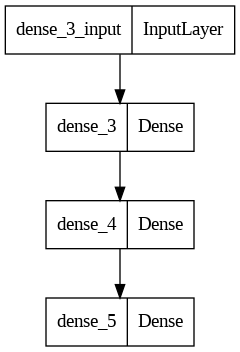

In [24]:
plot_model(model, to_file='model.png')

#Training

In [25]:
start = time.time()
history = model.fit(xtr, ytr, validation_data=(xva, yva), epochs=50, batch_size=1, verbose=0)
end = time.time()
print('execution time:',end - start)

execution time: 142.7229769229889


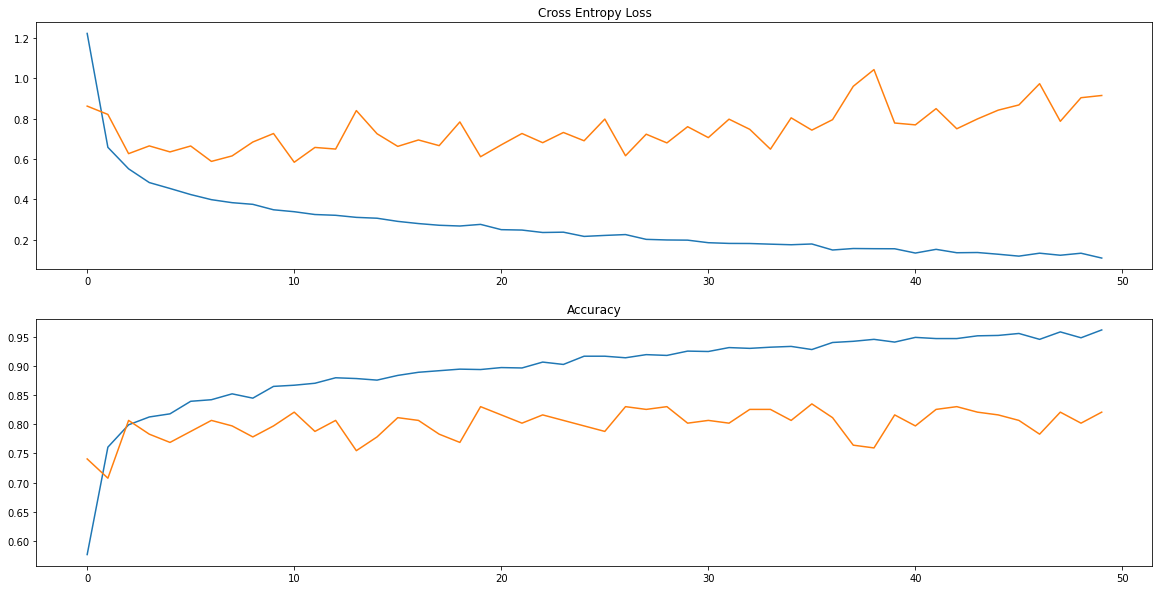

In [26]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Cross Entropy Loss")

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")

plt.show()

In [27]:
scores = model.evaluate(xtr, ytr, verbose=0)
print("Train %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train accuracy: 96.77%


In [28]:
ytr_pred = model.predict(xtr, verbose=0)
ytr_pred=np.argmax(ytr_pred,axis=1)
print("Train Accuracy by model.predict: %.2f%%" % (100*sum(ytr_bool == ytr_pred)/ytr.shape[0]))

Train Accuracy by model.predict: 96.77%


In [29]:
yva_pred=model.predict(xva)
yva_pred=np.argmax(yva_pred,axis=1)
print("Val Accuracy by model.predict: %.2f%%" % (100*sum(yva_bool == yva_pred)/yva.shape[0]))

7/7 [==============================] - 0s 3ms/step
Val Accuracy by model.predict: 82.08%


In [30]:
yte_pred = model.predict(xte, batch_size=1, verbose=0)
yte_pred_bool = np.argmax(yte_pred, axis=1)
print("Test Accuracy by model.predict: %.2f%%" % (100*sum(yte_bool == yte_pred_bool)/yte.shape[0]))

Test Accuracy by model.predict: 80.52%


In [31]:
# Matthews correlation coefficient
print("Train MMC: ", matthews_corrcoef(ytr_bool, ytr_pred))
print("Val MMC: ", matthews_corrcoef(yva_bool, yva_pred))
print("Test MMC: ", matthews_corrcoef(yte_bool, yte_pred_bool))

print("---------------TRAIN---------------------")
print(confusion_matrix(ytr_bool, ytr_pred))
print("---------------VAL---------------------")
print(confusion_matrix(yva_bool, yva_pred))
print("---------------TEST---------------------")
print(confusion_matrix(yte_bool, yte_pred_bool))

Train MMC:  0.9615942401212306
Val MMC:  0.7912177906371457
Test MMC:  0.7663637916818351
---------------TRAIN---------------------
[[247   5   5   0   2   0   0   0   0   3]
 [  1 407   1   1   0   1   0   0   0   0]
 [  1   0  42   0   0   0   0   0   0   0]
 [  0   0   0  53   0   0   0   0   0   0]
 [  0   1   0   0  48   0   0   0   0   2]
 [  0   1   0   0   0 230   1   0   0   0]
 [  2   0   0   0   0   2 163   0   0   0]
 [  0   0   0   0   0   0   0  80   0   0]
 [  2   0   0   0   0   0   0   0  43   4]
 [  8   0   0   0   1   0   0   0   4 127]]
---------------VAL---------------------
[[23  7  2  0  1  0  1  0  0  3]
 [ 0 46  0  0  0  1  0  0  0  0]
 [ 1  0  2  0  0  0  0  0  0  0]
 [ 0  3  0  8  0  0  0  0  0  0]
 [ 1  1  0  0  8  0  0  0  1  0]
 [ 1  1  0  0  0 31  0  0  0  0]
 [ 3  1  0  0  0  4 29  2  0  1]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  3  1]
 [ 1  0  0  0  1  0  0  0  0 17]]
---------------TEST---------------------
[[ 60  11   5   0   1   0

In [32]:
print("Train %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Train Accuracy by model.predict: %.2f%%" % (100*sum(ytr_bool == ytr_pred)/ytr.shape[0]))
print("Val Accuracy by model.predict: %.2f%%" % (100*sum(yva_bool == yva_pred)/yva.shape[0]))
print("Test Accuracy by model.predict: %.2f%%" % (100*sum(yte_bool == yte_pred_bool)/yte.shape[0]))
# Matthews correlation coefficient
print("Train MMC: ", matthews_corrcoef(ytr_bool, ytr_pred))
print("Val MMC: ", matthews_corrcoef(yva_bool, yva_pred))
print("Test MMC: ", matthews_corrcoef(yte_bool, yte_pred_bool))

print("---------------TRAIN---------------------")
print(confusion_matrix(ytr_bool, ytr_pred))
print("---------------VAL---------------------")
print(confusion_matrix(yva_bool, yva_pred))
print("---------------TEST---------------------")
print(confusion_matrix(yte_bool, yte_pred_bool))

Train accuracy: 96.77%
Train Accuracy by model.predict: 96.77%
Val Accuracy by model.predict: 82.08%
Test Accuracy by model.predict: 80.52%
Train MMC:  0.9615942401212306
Val MMC:  0.7912177906371457
Test MMC:  0.7663637916818351
---------------TRAIN---------------------
[[247   5   5   0   2   0   0   0   0   3]
 [  1 407   1   1   0   1   0   0   0   0]
 [  1   0  42   0   0   0   0   0   0   0]
 [  0   0   0  53   0   0   0   0   0   0]
 [  0   1   0   0  48   0   0   0   0   2]
 [  0   1   0   0   0 230   1   0   0   0]
 [  2   0   0   0   0   2 163   0   0   0]
 [  0   0   0   0   0   0   0  80   0   0]
 [  2   0   0   0   0   0   0   0  43   4]
 [  8   0   0   0   1   0   0   0   4 127]]
---------------VAL---------------------
[[23  7  2  0  1  0  1  0  0  3]
 [ 0 46  0  0  0  1  0  0  0  0]
 [ 1  0  2  0  0  0  0  0  0  0]
 [ 0  3  0  8  0  0  0  0  0  0]
 [ 1  1  0  0  8  0  0  0  1  0]
 [ 1  1  0  0  0 31  0  0  0  0]
 [ 3  1  0  0  0  4 29  2  0  1]
 [ 0  0  0  0  0  0  0  7 